# Detection of Twitter users using hateful lexicon, baselines using LR and MLP

**References**

1. "Like Sheep Among Wolves": Characterizing Hateful Users on Twitter. M. H. Ribeiro, P. H. Calais, Y. A. Santos, V. A. F. Almeida, and W. Meira Jr.  arXiv preprint arXiv:1801.00317 (2017).


2. Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 


3. Graph Attention Networks. P. Velickovic et al. ICLR 2018


4. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017.

In [109]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import copy

from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Loading the data

In [110]:
data_dir = os.path.expanduser("../twitter_data/public")

### First load and prepare the node features

Each node in the graph is associated with a large number of features (also referred to as attributes). 

The list of features is given [here](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter). 

hate :("hateful"|"normal"|"other")
  if user was annotated as hateful, normal, or not annotated.
  
  (is_50|is_50_2) :bool
  whether user was deleted up to 12/12/17 or 14/01/18. 
  
  (is_63|is_63_2) :bool
  whether user was suspended up to 12/12/17 or 14/01/18. 
        
  (hate|normal)_neigh :bool
  is the user on the neighborhood of a (hateful|normal) user? 
  
  [c_] (statuses|follower|followees|favorites)_count :int
  number of (tweets|follower|followees|favorites) a user has.
  
  [c_] listed_count:int
  number of lists a user is in.

  [c_] (betweenness|eigenvector|in_degree|outdegree) :float
  centrality measurements for each user in the retweet graph.
  
  [c_] *_empath :float
  occurrences of empath categories in the users latest 200 tweets.

  [c_] *_glove :float          
  glove vector calculated for users latest 200 tweets.
  
  [c_] (sentiment|subjectivity) :float
  average sentiment and subjectivity of users tweets.
  
  [c_] (time_diff|time_diff_median) :float
  average and median time difference between tweets.
  
  [c_] (tweet|retweet|quote) number :float
  percentage of direct tweets, retweets and quotes of an user.
  
  [c_] (number urls|number hashtags|baddies|mentions) :float
  number of bad words|mentions|urls|hashtags per tweet in average.
  
  [c_] status length :float
  average status length.
  
  hashtags :string
  all hashtags employed by the user separated by spaces.
  
**Notice** that c_ are attributes calculated for the 1-neighborhood of a user in the retweet network (averaged out).

In [111]:
users_feat = pd.read_csv(os.path.join(data_dir, 'users_neighborhood_anon.csv'))
users_feat.head()

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698


In [5]:
print("Initial hateful/normal users distribution")
print(users_feat.shape)
print(users_feat.hate.value_counts())

Initial hateful/normal users distribution
(100386, 1039)
other      95415
normal      4427
hateful      544
Name: hate, dtype: int64


### Removing Graph related features

In [6]:
def remove_graphical_features(feat, dropc = True, dropglove = True, dropsentiment = True, drophashtag = True):
    feat = feat.drop(columns=["hate_neigh", "normal_neigh"])
    
    # missing information
    number_of_missing = feat.isnull().sum()
    number_of_missing[number_of_missing!=0]
    
    # Replace NA with 0
    feat.fillna(0, inplace=True)

    # droping info about suspension and deletion as it is should not be use din the predictive model
    feat.drop(feat.columns[feat.columns.str.contains("is_")], axis=1, inplace=True)
    
    if dropglove:
        # drop glove features
        feat.drop(feat.columns[feat.columns.str.contains("_glove")], axis=1, inplace=True)
        
    if dropc:
        # drop c_ features
        feat.drop(feat.columns[feat.columns.str.contains("c_")], axis=1, inplace=True)

    if dropsentiment:
        # drop sentiment features for now
        feat.drop(feat.columns[feat.columns.str.contains("sentiment")], axis=1, inplace=True)

    if drophashtag:
        # drop hashtag feature
        feat.drop(['hashtags'], axis=1, inplace=True)

    # Drop centrality based measures
    feat.drop(columns=['betweenness', 'eigenvector', 'in_degree', 'out_degree'], inplace=True)
    
    feat.drop(columns=['created_at'], inplace=True)
    
    return feat

In [7]:
def convert_label_to_int(feat):
    # Convert target values in hate column from strings to integers (0,1,2)
    feat['hate'] = np.where(feat['hate']=='hateful', 1, np.where(feat['hate']=='normal', 0, 2))
    return feat

In [8]:
node_data = remove_graphical_features(users_feat)
node_data = convert_label_to_int(node_data)

Of the original **1037** node features, we are keeping only **204** that are based on a user's attributes and tweet lexicon. We have removed any manually engineered graph features since the graph neural network algorithms we are going to use will automatically determine the best features to use during training.

In [9]:
node_data.shape

(100386, 206)

In [11]:
# Set the dataframe index to be the same as the user_id and drop the user_id columns
node_data.index = node_data.index.map(str)
node_data.drop(columns=['user_id'], inplace=True)

### Splitting the data

60% train, 40% test

In [12]:
# choose the nodes annotated with normal or hateful classes
annotated_users = node_data[node_data['hate']!=2]

In [13]:
annotated_users.head()

,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,timidity_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,101767,3504,3673,81635,53,0.000513,0.002564,0.002564,0.003077,...,16.0,121.0,79.0,5.0,75.565,82.0,18.0,159.0,356.020101,74.0
22,0,111948,1586,997,80,7,0.001923,0.000641,0.001923,0.001282,...,4.0,187.0,13.0,54.0,56.175,74.0,17.0,113.0,2662.497487,125.0
29,0,28222,27545,282,916,499,0.006281,0.001759,0.002513,0.003769,...,22.0,178.0,22.0,29.0,131.685,108.0,26.0,224.0,2742.698492,272.0
44,0,3101,2173,923,1193,11,0.008295,0.001659,0.002654,0.004313,...,87.0,55.0,145.0,6.0,135.485,188.0,18.0,203.0,51670.407035,21808.0
85,0,49169,2321,206,24755,37,0.002744,0.000549,0.007135,0.001647,...,21.0,143.0,57.0,14.0,98.165,115.0,11.0,148.0,4613.944724,322.0


In [14]:
annotated_users.shape

(4971, 205)

In [15]:
annotated_user_features = annotated_users.drop(columns=['hate'])
annotated_user_targets = annotated_users[['hate']]

In [16]:
print(annotated_user_targets.hate.value_counts())

0    4427
1     544
Name: hate, dtype: int64


In [17]:
# split the data
train_data, test_data, train_targets, test_targets = train_test_split(annotated_user_features,
                                         annotated_user_targets,
                                         test_size=0.40,
                                         random_state=101)
train_targets = train_targets.values
test_targets = test_targets.values
print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print("Train data number of 0s {} and 1s {}".format(np.sum(train_targets==0), 
                                                    np.sum(train_targets==1)))
print("Test data number of 0s {} and 1s {}".format(np.sum(test_targets==0), 
                                                   np.sum(test_targets==1)))

Sizes and class distributions for train/test data
Shape train_data (2982, 204)
Shape test_data (1989, 204)
Train data number of 0s 2647 and 1s 335
Test data number of 0s 1780 and 1s 209


In [18]:
train_targets.shape, test_targets.shape

((2982, 1), (1989, 1))

In [19]:
train_data.shape, test_data.shape

((2982, 204), (1989, 204))

We are going to use 2982 nodes for training and 1989 nodes for testing.

## Feature Normalization

The continous features in our dataset have distributions with very long tails. We apply normalization to correct for this.

In [20]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True) 

In [21]:
normalizer = pt.fit(train_data)
train_data_norm = normalizer.transform(train_data)
test_data_norm = normalizer.transform(test_data)
train_data.iloc[:, :] = train_data_norm
test_data.iloc[:, :] = test_data_norm

/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


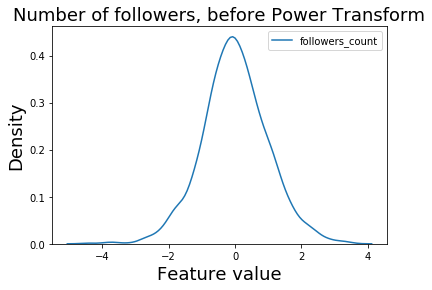

In [22]:
sns.kdeplot(train_data.iloc[:, 1])
s = plt.ylabel("Density", fontsize=18)
s = plt.xlabel("Feature value", fontsize=18)
s = plt.title("Number of followers, before Power Transform", fontsize=18)

### Dealing with imbalanced data 

In [24]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                     np.unique(train_targets), 
                                     train_targets[:,0])
train_class_weights = dict(zip(np.unique(train_targets), 
                               class_weights))
train_class_weights

{0: 0.5632791839818663, 1: 4.450746268656716}

### Logistic Regression

Train a Logistic Regression model entirely on the node features.

In [25]:
lr = LogisticRegressionCV(cv=5, 
                          class_weight=train_class_weights, 
                          max_iter=1000)  # Let's use the default parameters

In [26]:
lr.fit(train_data, train_targets.ravel())

LogisticRegressionCV(Cs=10,
                     class_weight={0: 0.5632791839818663, 1: 4.450746268656716},
                     cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=1000,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [90]:
test_preds_lr = lr.predict_proba(test_data)

#### Accuracy

In [91]:
lr.score(test_data, test_targets)

0.8446455505279035

#### Calculate AU-ROC metric

In [92]:
test_predictions_class_lr = ((test_preds_lr[:, 1]>0.5)*1).flatten()
test_df_lr = pd.DataFrame({"Predicted_score": test_preds_lr[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr, 
                        "True": test_targets[:,0]})
roc_auc_lr = metrics.roc_auc_score(test_df_lr['True'].values, test_df_lr['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc_lr)

The AUC on test set:

0.8709047900650503


#### The ROC curve

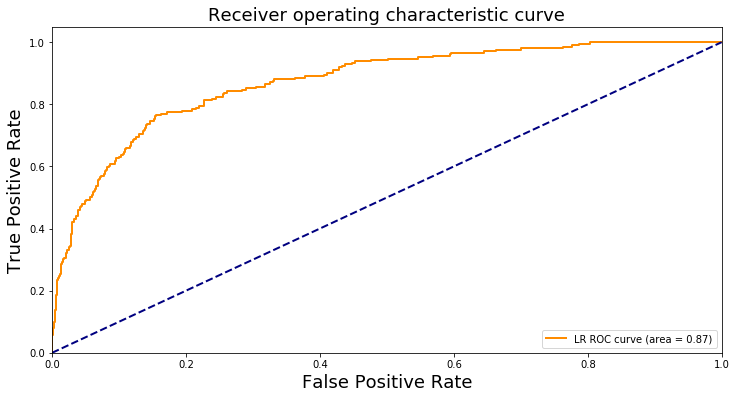

In [94]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(test_df_lr['True'], test_df_lr['Predicted_score'], pos_label=1)
plt.figure(figsize=(12,6,))
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='LR ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.savefig('/home/rj1408/dgnn/roc_lr.png')
plt.show()

## MLP

In [32]:
distr_size = 64
hidden_size = 128
n_layers = 1

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

In [33]:
class UserDataset(Dataset):
    
    def __init__(self, pandas_df, label_nparray):
        super().__init__()
        self.pd_df = pandas_df
        self.labels = label_nparray
            
    def __getitem__(self, i):
        return torch.FloatTensor(np.array(self.pd_df.iloc[i])), self.labels[i][0]
    
    def __len__(self):
        return self.pd_df.shape[0]

In [64]:
def predict(model, device, val_loader):
    model.eval()
    for batch_num, (inputs, _) in enumerate(val_loader):
        inputs = inputs.to(device)
        logits = model(inputs).view(-1)
        
        if batch_num == 0:
            all_logits = logits
        else:
            all_logits = torch.cat((all_logits, logits))
    return all_logits

In [35]:
#Code for supervised training
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, checkpoint_path, f, verbIter, hyperparams, num_epochs=25):
    metrics_dict = {}
    metrics_dict["train"] = {}
    metrics_dict["valid"] = {}
    metrics_dict["train"]["loss"] = {}
    metrics_dict["train"]["loss"]["epochwise"] = []
    metrics_dict["train"]["loss"]["stepwise"] = []
    metrics_dict["valid"]["loss"] = {}
    metrics_dict["valid"]["loss"]["epochwise"] = []
    metrics_dict["valid"]["loss"]["stepwise"] = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 9999999999999999

    for epoch in range(num_epochs):
        f.write('Epoch {}/{} \n'.format(epoch, num_epochs - 1))
        f.write('-' * 10)
        f.write('\n')
        f.flush()

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            n_samples = 0
            
            # Iterate over data.
            for batch_num, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                                
                # zero the parameter gradients
                optimizer.zero_grad()
                batchSize = inputs.size(0)
                n_samples += batchSize
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.view(-1,1))
                    
                    # statistics
                    running_loss += loss.item()
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                if batch_num % verbIter == 0:
                    # Metrics
                    epoch_loss = running_loss /n_samples

                    f.write('{} Loss: {:.4f} \n'.format(phase, epoch_loss))
                    f.flush()
                    
                    metrics_dict[phase]["loss"]["stepwise"].append(epoch_loss)
                
            # Metrics
            epoch_loss = running_loss /n_samples

            f.write('{} Loss: {:.4f} \n'.format(phase, epoch_loss))
            f.flush()
            
            metrics_dict[phase]["loss"]["epochwise"].append(epoch_loss)
            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'full_metrics': metrics_dict,
            'hyperparams': hyperparams
            }, '%s/net_epoch_%d.pth' % (checkpoint_path, epoch))

    f.write('Best val loss: {:4f} \n'.format(best_loss))
    f.flush()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
class MLP(nn.Module):
    def __init__(self,
                 inp_size,
                 distr_hidden,
                 mlp_hidden,
                 n_layers,
                 dropout):
        super(MLP, self).__init__()
        self.distrlayer = nn.Linear(inp_size, distr_hidden)
        self.layers = nn.ModuleList()
        # hidden layers
        for i in range(n_layers):
            self.layers.append(nn.Linear(distr_hidden, mlp_hidden))
        # output layer
        self.nonlinear = nn.ReLU()
        self.outlayer = nn.Linear(mlp_hidden, 1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        h = self.distrlayer(features)
        h = self.nonlinear(h)
        h = self.dropout(h)
        for i, layer in enumerate(self.layers):
            h = layer(h)
            h = self.nonlinear(h)
            h = self.dropout(h)
        h = self.outlayer(h)
        return h

In [37]:
model_dir = '/misc/vlgscratch4/BrunaGroup/rj1408/dynamic_nn/models/static_gcn/twitter/mlp/1layer_64dist_128hid/'
train_dataset = UserDataset(train_data, train_targets)
test_dataset = UserDataset(test_data, test_targets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
dataloaders = {}
dataloaders["train"] = train_loader
dataloaders["valid"] = test_loader
model = MLP(train_data.shape[1], distr_size, hidden_size, n_layers, 0.2)
model.to(current_device)
criterion = nn.BCEWithLogitsLoss().to(current_device)#pos_weight=torch.FloatTensor([train_class_weights[1]]).to(current_device))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.01, weight_decay = 5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
f = open(os.path.join(model_dir,'training_logs.txt'), 'w+')
options = {
    "n_layers":1,
    "distr_size":64,
    "mlp_size":128
}
bst_model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, current_device, model_dir, f, 10, options, 32)

/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


## Evaluation of MLP

In [86]:
predictions_logits = predict(bst_model, current_device, test_loader)
sigLayer = nn.Sigmoid()
predictions_scores = sigLayer(predictions_logits).cpu().detach().numpy()
targets = test_targets.squeeze(1)

roc_auc_mlp = metrics.roc_auc_score(targets, predictions_scores)
print("The AUC on test set:\n")
print(roc_auc_mlp)

The AUC on test set:

0.8916429224235255


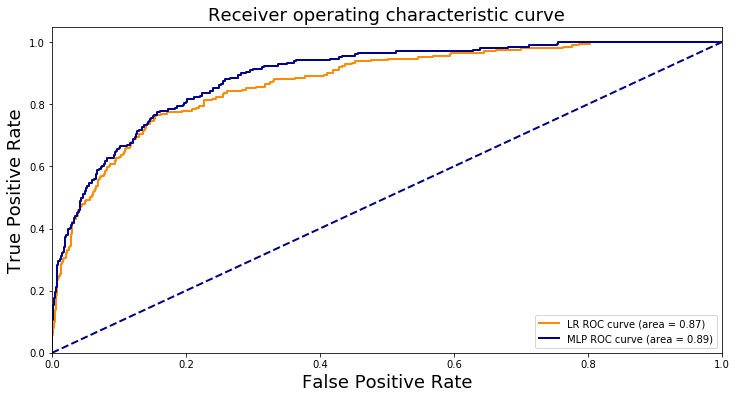

In [96]:
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(targets, predictions_scores, pos_label=1)
plt.figure(figsize=(12,6,))
lw = 2

plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='LR ROC curve (area = %0.2f)' % roc_auc_lr)

plt.plot(fpr_mlp, tpr_mlp, color='darkblue',
         lw=lw, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.savefig("/home/rj1408/dgnn/roc_mlp.png")
plt.show()